In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widjets
%matplotlib inline

import numpy as np
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import pandas as pd

import matplotlib.pyplot as plt

import os
import shutil
import cv2
from copy import deepcopy

from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from time import time
from tqdm import tqdm, tqdm_notebook

from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn import metrics
import json

from pathlib import Path
import segmentation_models_pytorch as smp

UAVid Dataset!



![](https://uavid.nl/UAVid_files/imgs/UAVid_example.png)

In [17]:
CLASS_TABLE = [{'name': 'Clutter','color':[0, 0, 0], 'class_num':0},
            {'name': 'Building','color':[128, 0, 0],'class_num':2},
            {'name': 'Road','color':[128, 64, 128],'class_num':1},
            {'name': 'Static_Car','color':[192, 0, 192],'class_num':4},
            {'name': 'Tree','color':[0, 128, 0],'class_num':0},
            {'name': 'Vegetation','color':[128, 128, 0],'class_num':0},
            {'name': 'Human','color':[64, 64, 0],'class_num':3},
            {'name': 'Moving_Car','color':[64, 0, 128],'class_num':4}]

def make_labeled_mask(img, CLASS_TABLE):
    img = img.copy()
    mask = np.zeros(img.shape[:2], dtype=np.int32)

    for cls in CLASS_TABLE:
        c = cls['color']
        label = (img[:,:,0] == c[0]) & (img[:,:,1] == c[1]) & (img[:,:,2] == c[2])
        
        if cls['name'] == 'Human': # сделаем метки хуманов более жирными
            a = label.astype(np.uint8)
            b = cv2.dilate(a,np.ones((5,5),np.uint8),iterations = 10)
            label = b==1
        mask[label] = cls['class_num']
    return mask


In [18]:
def create_save_masks():
    seq_paths = list(Path(r'Q:\Downloads\uavid_v1.5_official_release_image').glob(r'*\seq*'))

    for seq_p in tqdm_notebook(seq_paths):
        Labels_path = seq_p.joinpath('Labels')
        Masks_path = seq_p.joinpath('Masks')
        if not Masks_path.is_dir():
            Masks_path.mkdir()
            assert Masks_path.is_dir(), 'Fail to create directory:%s'%(str(Masks_path))

        labels = Labels_path.glob('*.png')
        for lbl_p in labels:
            img = cv2.cvtColor(cv2.imread(str(lbl_p)), cv2.COLOR_BGR2RGB)
            mask = make_labeled_mask(img, CLASS_TABLE)
            mask_path = Masks_path.joinpath(lbl_p.name)
            cv2.imwrite(str(mask_path), mask)
            
create_save_masks()

c:\python37\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [3]:
Train_PATH = Path(r'Q:\Downloads\uavid_v1.5_official_release_image\uavid_train')
Val_PATH = Path(r'Q:\Downloads\uavid_v1.5_official_release_image\uavid_val')

In [4]:
class UAVid_dataset(Dataset):
    CLASSES = ['Clutter', 'Building', 'Road', 'Car', 'Tree', 'Vegetation', 'Human']
    
    def __init__(self, data_path, augmentations=None, preprocessing=None) -> None:
        self.augmentations = augmentations
        self.preprocessing = preprocessing
        self.class_num = 7
        self.dataset = self.get_data_paths(data_path)
    
    def get_data_paths(self, dataset_path):
        dataset = []
        img_list = list(Path(dataset_path).glob('seq*\Images\*.png'))
        print(f'found {len(img_list)} images')
        for img_path in img_list:
            mask_path = list(img_path.parents)[1].joinpath('Masks', img_path.name)
            dataset.append({'img_path': img_path, 'mask_path': mask_path})
        return dataset
    
    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> dict:
        image = cv2.imread(str(self.dataset[idx]['img_path']))[:,:,::-1]
        mask  = cv2.imread(str(self.dataset[idx]['mask_path']))[:,:,0]
        
        masks = [(mask == v) for v in range(self.class_num)]
        mask = np.stack(masks, axis=-1).astype('float')
        
        result = {"image": image, "mask": mask}
        
        if self.augmentations is not None:
            result = self.augmentations(**result)
            
        # apply preprocessing
        if self.preprocessing:
            result = self.preprocessing(**result)
        
        return result['image'], result['mask']


In [5]:
DS = UAVid_dataset(Val_PATH)
@interact(i=(0,len(DS)-1, 1), mask_ch=(0,6,1))
def tst(i=0,mask_ch=1):
    img, mask = DS[i]

    plt.figure(figsize=(26, 36))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"{'Original Image'}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask[:,:,mask_ch])
    plt.title('MASK')

found 50 images


interactive(children=(IntSlider(value=0, description='i', max=49), IntSlider(value=1, description='mask_ch', m…

# AUGMENTATIONS

 ### Поскольку Stanford Drone Dataset (SDD) в крайне плачевном качестве (все заблюрено, жипег пожрал) - инференс буду проводить на полных картинках (без уменьшения). в SDD картинки размера ~1300х1300 с размером человечка ~25х25. Буду отталкиваться от размера человечка.

### Да у UAVid датасета, домен картинок чуть другой, поэтому буду максимально близко (к SDD) семплировать картинки. Т.е. посмотрим размеры человечков в UAVid.

Q:\Downloads\uavid_v1.5_official_release_image\uavid_train\seq1\Masks\000000.png


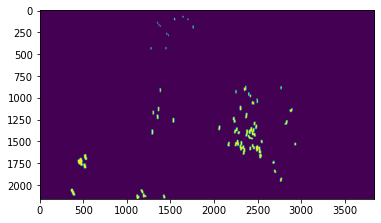

In [322]:
mask_paths = list(Path(r'Q:\Downloads\uavid_v1.5_official_release_image\uavid_train').glob('*\Masks\*.png'))
mask = cv2.imread(str(mask_paths[0]))[:,:,0]
mask = mask==6
print(str(mask_paths[0]))
plt.imshow(mask)

### Поскольку маски отдельных людей слиплись, попробуем их разделить watershed'ом

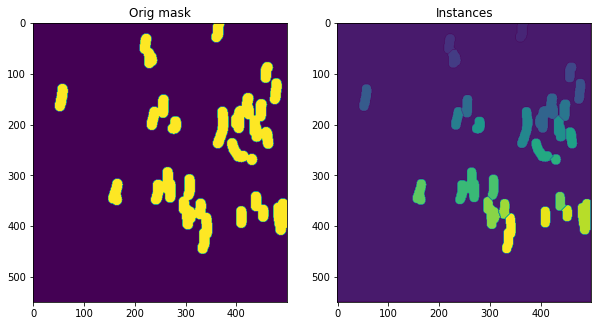

In [308]:
def watershed(img):
    kernel = np.ones((3,3),np.int32)

    sure_bg = cv2.dilate(img,kernel,iterations=3)

    dist_transform = cv2.distanceTransform(img,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,10,255,0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    mask_instance = cv2.watershed(np.stack([img,img,img], axis=-1), markers)
          
    return mask_instance

img = (mask[1200:1750, 2000:2500]*255).astype(np.uint8)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title(f"{'Orig mask'}")
plt.imshow(img)


mask_instance = watershed(img)
plt.subplot(1,2,2)
plt.title(f"{'Instances'}")
plt.imshow(mask_instance)

In [332]:
Y_max, X_max = [], []

mask_paths = list(Path(r'Q:\Downloads\uavid_v1.5_official_release_image\uavid_train').glob('*\Masks\*.png'))
for mask_p in tqdm_notebook(mask_paths):
    mask = cv2.imread(str(mask_p))[:,:,0]
    mask = ((mask==6)*255).astype(np.uint8)
    instance_mask = watershed(mask)
    for lbl in np.unique(instance_mask)[2:]:
        y,x = np.where(instance_mask==2)
        Y_max.append(y.max() - y.min())
        X_max.append(x.max()-x.min())

c:\python37\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0

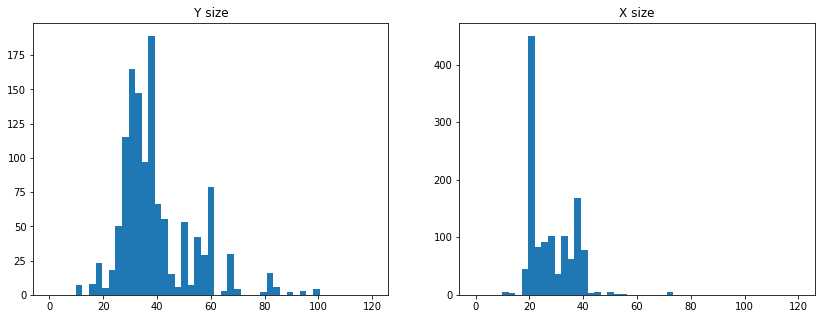

In [353]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title(f"{'Y size'}")
plt.hist(Y_max, bins=np.linspace(0,120,50))

plt.subplot(1,2,2)
plt.title(f"{'X size'}")
plt.hist(X_max, bins=np.linspace(0,120,50))
0

## Как оказалось - большая масса людей на снимках в датасете UAVid как раз размера 20-40 пикс, поэтому буду просто учить на кропах, не изменяя размер всей картинки.

In [6]:
import albumentations as albu
from albumentations.pytorch import ToTensor

BORDER_CONSTANT = 0
BORDER_REFLECT = 2

def pre_transforms(smallest_size=2160, crop_size=724):
    return albu.Compose([
#         albu.SmallestMaxSize(max_size=smallest_size, interpolation=cv2.INTER_LINEAR, always_apply=True),
        albu.RandomCrop(crop_size,crop_size),
#         albu.LongestMaxSize(max_size=crop_size),
#         albu.PadIfNeeded(image_size, image_size, border_mode=BORDER_CONSTANT, value=0)
    ])


def hard_transforms():
    return albu.Compose([
        albu.ShiftScaleRotate (shift_limit=0, scale_limit=0.1, rotate_limit=180, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, value=(0,0,0), mask_value=0),
        albu.HueSaturationValue(p=0.3),
        albu.OneOf([
            albu.IAAAdditiveGaussianNoise(),
            albu.GaussNoise(),
            albu.MultiplicativeNoise(multiplier=[0.5, 1.5], per_channel=True, p=1)
        ], p=0.3),
        albu.OneOf([
            albu.MotionBlur(p=0.2),
            albu.MedianBlur(blur_limit=3, p=0.1),
            albu.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        albu.OneOf([
            albu.CLAHE(clip_limit=2),
            albu.IAASharpen(),
            albu.IAAEmboss(),
            albu.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
            albu.RandomGamma(gamma_limit=(85, 115), p=0.3),
        ], p=0.3),
        albu.JpegCompression(quality_lower=40, quality_upper=100, p=0.5),
        albu.Cutout(num_holes=25, max_h_size=10, max_w_size=10, fill_value=0, p=0.5),
        ], p=1)

def post_transforms():
    return albu.Compose([
        albu.CenterCrop(height=512, width=512, p=1)],
#         albu.Normalize(),
#         ToTensor()],
        p=1)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


train_transforms = albu.Compose([
    hard_transforms(),
    post_transforms()
])

valid_transforms = albu.Compose([pre_transforms(), post_transforms()])

show_transforms = albu.Compose([pre_transforms(), hard_transforms()])

In [7]:
Val_PATH = Path(r'Q:\Downloads\uavid_v1.5_official_release_image\uavid_val')
DS = UAVid_dataset(Val_PATH, augmentations=train_transforms)
@interact(i=(0,len(DS)-1, 1), mask_ch=(0,6,1))
def tst(i=0,mask_ch=1):
    img, mask = DS[i]

    plt.figure(figsize=(26, 36))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"{'Original Image'}")

    plt.subplot(1, 2, 2)
    plt.imshow(mask[:,:,mask_ch])
    plt.title('MASK')

found 50 images


interactive(children=(IntSlider(value=0, description='i', max=49), IntSlider(value=1, description='mask_ch', m…

# Model


In [5]:
import segmentation_models_pytorch as smp

ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'

model = smp.FPN(encoder_name=ENCODER, 
                 encoder_weights=ENCODER_WEIGHTS, 
                 classes=7
               )

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
CLASSES = ['Clutter', 'Building', 'Road', 'Car', 'Tree', 'Vegetation', 'Human']

In [6]:
def get_val_batches(valid_loader):
    '''
    We should validate model on the same images through epoches.
    :return: list of batches
    '''
    Val_batches = []
    for i in tqdm(range(10)):
        for image, mask in tqdm(valid_loader):
            Val_batches.append([image, mask])
    return Val_batches


batch_size = 1
Train_PATH = r'Q:\Downloads\uavid_v1.5_official_release_image\uavid_train'
Val_PATH = r'Q:\Downloads\uavid_v1.5_official_release_image\uavid_val'

train_dataset = UAVid_dataset(Train_PATH, augmentations=train_transforms, preprocessing=get_preprocessing(preprocessing_fn))
valid_dataset = UAVid_dataset(Val_PATH, augmentations=valid_transforms, preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)
# valid_loader = get_val_batches(valid_loader)


loaders = {
    "train": train_loader,
    "valid": valid_loader
}

found 230 images
found 40 images


In [7]:
from torch import nn
from catalyst.contrib.nn import DiceLoss, IoULoss, RAdam, Lookahead, OneCycleLRWithWarmup
from catalyst.dl import SupervisedRunner

logdir = "./logs"
num_epochs = 300
learning_rate = 1e-3
base_optimizer = RAdam([
    {'params': model.decoder.parameters(), 'lr': learning_rate}, 
    {'params': model.encoder.parameters(), 'lr': 1e-4},
    {'params': model.segmentation_head.parameters(), 'lr': learning_rate},
], weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}
runner = SupervisedRunner(device='cuda', input_key="image", input_target_key="mask")
scheduler = OneCycleLRWithWarmup(
    optimizer, 
    num_steps=num_epochs, 
    lr_range=(0.0016, 0.0000001),
    init_lr = learning_rate,
    warmup_steps=2
)

In [8]:
from catalyst.dl import DiceCallback, IouCallback, CriterionCallback, MetricAggregationCallback, ClasswiseIouCallback, WandbLogger

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),
#     ClasswiseIouCallback(
#         input_key="mask",
#         prefix='iou_clswise',
#         classes=CLASSES
#     ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
#     IouCallback(input_key="mask"),
    
    
]


In [ ]:
model.train()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by Dice metric
    main_metric="dice",
    minimize_metric=False,
    fp16=dict(opt_level="O1"),
    verbose=True,
)

#  EVAL


In [2]:
import segmentation_models_pytorch as smp

ENCODER = 'timm-resnest14d'
ENCODER_WEIGHTS = 'imagenet'

model = smp.FPN(encoder_name=ENCODER, 
                 encoder_weights=ENCODER_WEIGHTS, 
                 classes=7
               )

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [3]:
model.load_state_dict(torch.load(r'Z:\test tasks\Sber_robo\project\logs\checkpoints\best_full.pth')['model_state_dict'])
model.eval().cuda()
print('model loaded')

model loaded


In [7]:
CLASSES = ['Clutter', 'Building', 'Road', 'Car', 'Tree', 'Vegetation', 'Human']
DEFAULT_COLORS = ('red', 'blue', 'yellow', 'magenta', 'green', 'indigo', 'darkorange', 'cyan', 'pink', 'yellowgreen')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

patches = []
for i, cls in enumerate(CLASSES):
    patches.append(mpatches.Patch(color=DEFAULT_COLORS[i], label=cls))

def mask_to_overlay_image(image, labels, mask_strength=0.5):
    from skimage.color import label2rgb
    
    mask = label2rgb(labels, bg_label=-1) 

    image = np.array(image) / 255.0
    image_with_overlay = image * (1 - mask_strength) + mask * mask_strength
    image_with_overlay = (
        (image_with_overlay * 255).clip(0, 255).round().astype(np.uint8)
    )

    return image_with_overlay

## Inference on UAVid

In [9]:
from project.transforms import valid_transforms

In [10]:

Val_PATH = r'Q:\Downloads\uavid_v1.5_official_release_image\uavid_val'
val_list = list(Path(Val_PATH).glob('seq*\Images\*.png'))

Inference_images = []
Inference_masks = []
with torch.no_grad():
    for img_p in tqdm_notebook(list(val_list)):
        img = valid_transforms(image=cv2.imread(str(img_p))[:,:,::-1])['image']
        tensor_img = preprocess_tr(image=img)['image'].unsqueeze(0)
        preds = model(tensor_img.cuda())
        
        Inference_images.append(img)
        Inference_masks.append(torch.argmax(preds[0], dim=0).cpu().detach().numpy())

c:\python37\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [11]:
@interact(i=(0,len(Inference_images)-1,1))
def tst(i=0):
    img = Inference_images[i]
    masks = Inference_masks[i]
    
    plt.figure(figsize=(25,20))
    plt.subplot(2,1,1)
    plt.imshow(img)
    
    plt.subplot(2,1,2)
    
    a = mask_to_overlay_image(img, masks)
    plt.legend(handles=patches, ncol=7, bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    plt.imshow(a)


interactive(children=(IntSlider(value=0, description='i', max=49), Output()), _dom_classes=('widget-interact',…

## Inference on SDD 

In [30]:
import albumentations as albu
import cv2
from albumentations.pytorch import ToTensor

BORDER_CONSTANT = 0
def pre_transforms(image_size):
    return albu.Compose([
        albu.LongestMaxSize(max_size=image_size, always_apply=True),
        albu.PadIfNeeded(min_height=None, min_width=None, pad_height_divisor=32, pad_width_divisor=32, border_mode=BORDER_CONSTANT, value=0),
    ])

def Inference_transform(preprocessing_fn):
    return albu.Compose([
        albu.Lambda(name='my_transform', image=preprocessing_fn),
        ToTensor(),
    ])

preprocess_tr = Inference_transform(preprocessing_fn)

In [31]:
images_paths = Path(r'Q:\Downloads\stanford_campus_dataset\annotations').glob('*/*/reference.jpg')

Inference_images = []
Inference_masks = []
with torch.no_grad():
    for img_p in tqdm_notebook(list(images_paths)):
        img = cv2.imread(str(img_p))[:,:,::-1]
        img = pre_transforms(max(img.shape[:2])/4)(image=img)['image']
        
        
        tensor_img = preprocess_tr(image=img)['image'].unsqueeze(0)
        preds = model(tensor_img.cuda())
        
        Inference_images.append(img)
        Inference_masks.append(torch.argmax(preds[0], dim=0).cpu().detach().numpy())

c:\python37\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [32]:
@interact(i=(0,len(Inference_images)-1,1))
def tst(i=0):
    img = Inference_images[i]
    masks = Inference_masks[i]
    
    plt.figure(figsize=(15,20))
    plt.subplot(1,2,1)
    plt.imshow(img)
    
    plt.subplot(1,2,2)
    
    a = mask_to_overlay_image(img, masks)
    plt.legend(handles=patches, ncol=7, bbox_to_anchor=(-0.1, 1),
              loc='lower left', fontsize='small')
    plt.imshow(a)


interactive(children=(IntSlider(value=0, description='i', max=59), Output()), _dom_classes=('widget-interact',…

### На деревьях, траве, зданиях, машинах +- работает. Людей эта модель ищет крайне плохо.
### Метрик нету, т.к. разметки на эти классы в SDD нету.